# Pathway identification workflow related to DataCure and AOPlink case studies
This notebook downloads TG-Gates data of 4 compounds and selects genes overexpressed in all sample. The Affymetrix probe sets are then translated into Ensembl gene identifiers using the BridgeDB service and pathways associated with the genes are identified using the WikiPathways service.

In [1]:
!pip install sparqlwrapper

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import requests
from IPython.display import display, SVG, HTML
import pandas

## Selection of compounds of interest

In [3]:
import urllib

def smiles_to_image_html(smiles):
    return '<img style="width:150px" src="http://chemidconvert.cloud.douglasconnect.com/v1/asSvg?smiles={}"/>'.format(urllib.parse.quote(smiles))

pandas.set_option('display.max_colwidth', -1)

compounds = pandas.DataFrame(columns=['Compound name', 'Smiles', 'Image'])

compoundset = {'methapyrilene', 'phenylbutazone', 'simvastatin', 'valproic acid'}
for compound in compoundset:
    compoundreq = requests.get('https://chemidconvert.cloud.douglasconnect.com/v1/name/to/smiles', params={'name': compound});
    smiles = compoundreq.json()['smiles']
    compounds = compounds.append({'Compound name': compound, 'Smiles': smiles, 'Image': smiles}, ignore_index=True)
    
HTML(compounds.to_html(escape=False ,formatters=dict(Image=smiles_to_image_html)))
#HTML(compounds.to_html(escape=False))

,Compound name,Smiles,Image
0,phenylbutazone,CCCCC1C(=O)N(N(C1=O)c2ccccc2)c3ccccc3,
1,methapyrilene,CN(C)CCN(Cc1sccc1)c2ccccn2,
2,simvastatin,CCC(C)(C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C)[C@H](CC[C@@H]3C[C@@H](O)CC(=O)O3)[C@@H]12,
3,valproic acid,CCCC(CCC)C(O)=O,


## Identification and download of TG-Gates data

In [4]:
compounds = ""
for compound in compoundset:
    if compounds == "": 
        compounds = compound
    else:
        compounds = compounds+"|"+compound

print(compounds)    
r2 = requests.get('http://open-tggates-api.cloud.douglasconnect.com/v2/samples', 
                  params={'limit': 10000,
                          'compoundNameFilter': compounds, 
                          'organismFilter': 'Human',
                          'tissueFilter': 'Liver', 
                          'cellTypeFilter': 'in vitro',
                          'repeatTypeFilter': 'Single' 
                        , 'timepointHrFilter': '24.0' 
                        , 'doseLevelFilter': 'High'
                          });

print("TGGATES Status code: {0}".format(r2.status_code))
if r2.status_code == 200:
    samples = r2.json()

samples['samples']

phenylbutazone|methapyrilene|simvastatin|valproic acid
TGGATES Status code: 200


[{'_id_': '003016020014',
  'cellType': 'in vitro',
  'compoundName': 'methapyrilene',
  'controlSamples': [],
  'doseLevel': 'High',
  'organism': 'Human',
  'repeatType': 'Single',
  'sampleId': '003016020014',
  'timepointHr': 24.0,
  'tissue': 'Liver'},
 {'_id_': '003016020015',
  'cellType': 'in vitro',
  'compoundName': 'methapyrilene',
  'controlSamples': [],
  'doseLevel': 'High',
  'organism': 'Human',
  'repeatType': 'Single',
  'sampleId': '003016020015',
  'timepointHr': 24.0,
  'tissue': 'Liver'},
 {'_id_': '003016014002',
  'cellType': 'in vitro',
  'compoundName': 'phenylbutazone',
  'controlSamples': [],
  'doseLevel': 'High',
  'organism': 'Human',
  'repeatType': 'Single',
  'sampleId': '003016014002',
  'timepointHr': 24.0,
  'tissue': 'Liver'},
 {'_id_': '003016014003',
  'cellType': 'in vitro',
  'compoundName': 'phenylbutazone',
  'controlSamples': [],
  'doseLevel': 'High',
  'organism': 'Human',
  'repeatType': 'Single',
  'sampleId': '003016014003',
  'timepoin

In [5]:
for sample in samples["samples"]:
    sampleId = sample["sampleId"]
    sampleName = sample["compoundName"]+"\n"+sample["sampleId"]
    r3 = requests.get('http://open-tggates-api.cloud.douglasconnect.com/v2/results', 
                  params={'limit': 'none', 'sampleIdFilter': sampleId, 'valueTypeFilter': 'log2fold', 'pValueMax': '0.1'});

    if r3.status_code == 200:
        data = r3.json()
        df = pandas.DataFrame(data['results'])
        df = df.filter(items=['assayId','value'])
        df.columns = ['ProbeSet', sampleName]
#        df = df.set_index('ProbeSet')
    
    try:
        foldchanges.empty
    except NameError:
        foldchanges = df
    else:
        foldchanges = pandas.merge(foldchanges, df, how='outer', on=['ProbeSet'])

In [6]:
high = True

for sample in samples["samples"]:
    sampleId = sample["sampleId"]
    sampleName = sample["compoundName"]+"\n"+sample["sampleId"]
    high = high & (foldchanges[sampleName] >= 1.)
    
foldchanges = foldchanges[high]

In [7]:
foldchanges

,ProbeSet,methapyrilene 003016020014,methapyrilene 003016020015,phenylbutazone 003016014002,phenylbutazone 003016014003,simvastatin 003016079002,simvastatin 003016079003,valproic acid 003016038010,valproic acid 003016038011
217,243015_at,3.550345,3.607312,5.363620,5.425791,2.572754,2.564547,3.676939,3.807503
1105,229477_at,2.330954,2.191222,3.304727,3.415220,4.319531,4.132099,4.195705,3.802112
1106,229476_s_at,2.633772,2.882779,3.941051,3.899513,4.813974,4.702100,4.504707,4.460230
1376,227909_at,1.707718,1.954088,1.283314,1.484967,1.384484,1.640825,2.397012,2.142758
5361,208928_at,1.113596,1.250744,1.776669,1.682174,1.458460,1.429573,1.624269,1.398186
5604,207275_s_at,1.071509,1.147782,1.492939,1.539038,1.506103,1.431030,1.911157,1.826470
5764,205999_x_at,2.640015,2.349996,5.827156,5.702978,4.350264,4.210010,4.211109,3.934326
5773,205939_at,3.221563,3.000548,5.963379,5.733314,4.347017,4.373431,3.426144,3.077940
6991,201627_s_at,2.507150,2.567229,2.178763,2.132357,2.298643,2.169345,1.799169,1.656467
6993,201625_s_at,2.420876,2.454265,2.004699,2.082050,2.157720,2.225040,1.357678,1.223833


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

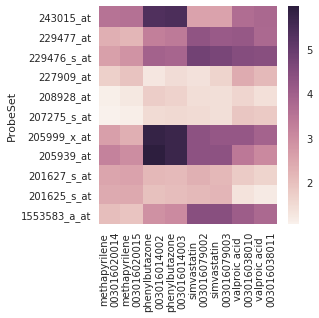

In [9]:
for_vis = foldchanges.set_index('ProbeSet')
plt.figure(figsize=(4, 4))
sns.set(font="Dejavu sans")
sns_plot = sns.heatmap(for_vis)
sns_plot

## Convertion of probe sets to Ensembl gene identifiers 

In [10]:
def getEnsembl(url):
    request3 = requests.get("http://bridgedb-swagger.prod.openrisknet.org/Human/xrefs/X/"+url+"?dataSource=En")
    return request3.text.split("\t")[0]

foldchanges['Ensembl'] = foldchanges.ProbeSet.apply(getEnsembl)

In [11]:
foldchanges

,ProbeSet,methapyrilene 003016020014,methapyrilene 003016020015,phenylbutazone 003016014002,phenylbutazone 003016014003,simvastatin 003016079002,simvastatin 003016079003,valproic acid 003016038010,valproic acid 003016038011,Ensembl
217,243015_at,3.550345,3.607312,5.363620,5.425791,2.572754,2.564547,3.676939,3.807503,ENSG00000106258
1105,229477_at,2.330954,2.191222,3.304727,3.415220,4.319531,4.132099,4.195705,3.802112,ENSG00000151365
1106,229476_s_at,2.633772,2.882779,3.941051,3.899513,4.813974,4.702100,4.504707,4.460230,ENSG00000151365
1376,227909_at,1.707718,1.954088,1.283314,1.484967,1.384484,1.640825,2.397012,2.142758,ENSG00000196972
5361,208928_at,1.113596,1.250744,1.776669,1.682174,1.458460,1.429573,1.624269,1.398186,ENSG00000127948
5604,207275_s_at,1.071509,1.147782,1.492939,1.539038,1.506103,1.431030,1.911157,1.826470,ENSG00000151726
5764,205999_x_at,2.640015,2.349996,5.827156,5.702978,4.350264,4.210010,4.211109,3.934326,ENSG00000160868
5773,205939_at,3.221563,3.000548,5.963379,5.733314,4.347017,4.373431,3.426144,3.077940,ENSG00000160870
6991,201627_s_at,2.507150,2.567229,2.178763,2.132357,2.298643,2.169345,1.799169,1.656467,ENSG00000186480
6993,201625_s_at,2.420876,2.454265,2.004699,2.082050,2.157720,2.225040,1.357678,1.223833,ENSG00000186480


## Listing of enriched pathways

In [12]:
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph

sparql = SPARQLWrapper("http://sparql.wikipathways.org")
sparql.setQuery("""
    select distinct ?pathwayRes str(?wpid) as ?pathway str(?title) as ?pathwayTitle fn:ENSG00000151365 as ?ensembl where {
      ?gene a wp:GeneProduct ;
        dcterms:identifier ?id ;
        dcterms:isPartOf ?pathwayRes ;
        wp:bdbEnsembl ?ensId .
      ?pathwayRes a wp:Pathway ;
        dcterms:identifier ?wpid ;
        dc:title ?title .
    }
""")

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [13]:
pathways = pandas.DataFrame(columns=['Ensembl', 'Pathway', 'Pathway Res', 'Pathway Title'])
for result in results["results"]["bindings"]:
    pathways = pathways.append({'Ensembl': result["ensembl"]["value"], 'Pathway': result["pathway"]["value"], 'Pathway Res': result["pathwayRes"]["value"], 'Pathway Title': result["pathwayTitle"]["value"], }, ignore_index=True)

pathways

,Ensembl,Pathway,Pathway Res,Pathway Title
0,http://www.w3.org/2005/xpath-functions/#ENSG00000151365,WP3141,http://identifiers.org/wikipathways/WP3141_r89804,BDNF signaling pathway
1,http://www.w3.org/2005/xpath-functions/#ENSG00000151365,WP3154,http://identifiers.org/wikipathways/WP3154_r90026,AMPK Signaling
2,http://www.w3.org/2005/xpath-functions/#ENSG00000151365,WP1050,http://identifiers.org/wikipathways/WP1050_r80921,Oxidative Stress
3,http://www.w3.org/2005/xpath-functions/#ENSG00000151365,WP1018,http://identifiers.org/wikipathways/WP1018_r95783,Apoptosis
4,http://www.w3.org/2005/xpath-functions/#ENSG00000151365,WP1040,http://identifiers.org/wikipathways/WP1040_r86949,Inflammatory Response Pathway
5,http://www.w3.org/2005/xpath-functions/#ENSG00000151365,WP1053,http://identifiers.org/wikipathways/WP1053_r86855,Estrogen metabolism
6,http://www.w3.org/2005/xpath-functions/#ENSG00000151365,WP1077,http://identifiers.org/wikipathways/WP1077_r80775,Oxidation by Cytochrome P450
7,http://www.w3.org/2005/xpath-functions/#ENSG00000151365,WP3163,http://identifiers.org/wikipathways/WP3163_r80733,Estrogen Receptor Pathway
8,http://www.w3.org/2005/xpath-functions/#ENSG00000151365,WP1065,http://identifiers.org/wikipathways/WP1065_r87970,Endochondral Ossification
9,http://www.w3.org/2005/xpath-functions/#ENSG00000151365,WP1075,http://identifiers.org/wikipathways/WP1075_r96339,Folate Metabolism
